346/346 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step
Optimized model evaluation:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1409
           1       0.73      0.64      0.69      1340

    accuracy                           0.71      2749
   macro avg       0.72      0.71      0.71      2749
weighted avg       0.71      0.71      0.71      2749



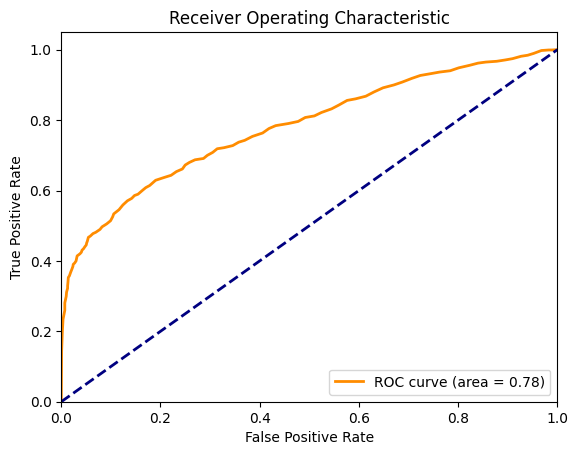

In [1]:
import numpy as np
import scipy.io as sio
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
import optuna
import pywt
from xgboost import XGBClassifier  # Make sure to import XGBClassifier

# Load the data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
Label = new['label_list'].flatten()
EEG = new['EEG']

# Feature extraction for ML
def extract_ml_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            # Statistical features
            mean = np.mean(channel_data)
            var = np.var(channel_data)
            skewness = skew(channel_data)
            kurt = kurtosis(channel_data)
            # Frequency domain features using Welch's method
            freqs, psd = welch(channel_data)
            psd_mean = np.mean(psd)
            psd_std = np.std(psd)
            # Combine all features
            sample_features.extend([mean, var, skewness, kurt, psd_mean, psd_std])
        features.append(sample_features)
    return np.array(features)

# Wavelet transform features
def extract_wavelet_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            coeffs = pywt.wavedec(channel_data, 'db4', level=4)
            for coeff in coeffs:
                sample_features.extend([np.mean(coeff), np.std(coeff)])
        features.append(sample_features)
    return np.array(features)

ml_features = extract_ml_features(EEG)
wavelet_features = extract_wavelet_features(EEG)
ml_features = np.concatenate((ml_features, wavelet_features), axis=1)

# Feature extraction for DL using CNN and LSTM
input_shape = (EEG.shape[0], EEG.shape[1], 1)

input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Reshape for LSTM layer
reshape_layer = Reshape((flatten.shape[1], 1))(flatten)
lstm_layer = LSTM(64)(reshape_layer)
dense1 = Dense(128, activation='relu')(lstm_layer)
output_layer = Dense(64, activation='relu')(dense1)  # Output for feature extraction

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer='adam', loss='mse')

# Reshape data for CNN input
data_cnn = EEG.reshape(EEG.shape[2], EEG.shape[0], EEG.shape[1], 1)

cnn_rnn_features = cnn_rnn_model.predict(data_cnn)

# Combine ML and DL features
combined_features = np.concatenate((ml_features, cnn_rnn_features), axis=1)

# Handle imbalanced data using SMOTE
smote = SMOTE()
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, Label)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resampled, labels_resampled, test_size=0.2, random_state=42)

# Best parameters found by Optuna
best_params = {'rf_n_estimators': 265, 'gb_n_estimators': 89, 'xgb_n_estimators': 300}

rf_clf = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'])
gb_clf = GradientBoostingClassifier(n_estimators=best_params['gb_n_estimators'])
xgb_clf = XGBClassifier(n_estimators=best_params['xgb_n_estimators'])

stacking_clf = StackingClassifier(estimators=[
    ('rf', rf_clf), 
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], final_estimator=RandomForestClassifier(n_estimators=100))

stacking_clf.fit(X_train, y_train)

# Evaluate the optimized model
y_pred_optimized = stacking_clf.predict(X_test)
print("Optimized model evaluation:")
print(classification_report(y_test, y_pred_optimized))

# Plotting the ROC curve and calculating AUC
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
